# Uncertainty in measurements of ice floe shapes
The IFT relies on similarity metrics to filter candidate floes and to find a best match. The current implementation uses a distance criterion (investigated in a separate notebook) and a two-stage shape similarity assessment. In each case the matching is based first on performance against thresholds. The thresholds are divided into "small" and "large" floe categories. In this notebook, we examine the results of a numerical experiment and a set of matched, manually validated floe pairs. We aim to understand:

* How sensitive is each measure to the uncertainty in the floe shape?
* How confident can we be in rejecting a match based on the results of the measures?
* How much power does each measure have at rejecting false matches?
* How much does the measure depend on the area of the floe?
  
With the threshold-based approach used in the algorithm, the best choice of threshold for a measure that increases monotonically with increasing difference between shapes is going to be one that is sufficiently high that true matches are unlikely to be rejected, while sufficiently low that a large number of non-matches are rejected. 

I am working toward the idea of casting this problem in Bayesian terms. Essentially, given a  a pair of objects $f$ and $g$ and collection of similarity measures $\theta(f, g)$ and, what is the probability $P(f = g | \theta(f, g))$?

Bayes theorem is just a shuffling of conditional properties, but may provide a useful framework for the question of floe matching.
$$ P(A | B) = \frac{P(A) P(B | A)}{P(B)}$$
In this case, we have $A$ being the probability that the floes are a true pair, and $B$ is the event of us getting a particular list of similarity measures. Let's think about the other 3 terms.

1. $P(A) = P(f = g)$. This is the prior. This could be 0, if $f$ was not observed in the second image. If we know that $f$ was observed then choosing it at random would happen in $1/n_{floes}$ times. However, we may also have more information: for example, if we had an estimate of the ice velocity field from neighboring floes or from the wind, or from a cross correlation estimate, we might be able to characterize the probability based on location.
3. $P(B | A)$. This is the probability of getting this particular set of similarity measures given that the floes are actually a match. This is the type of probability that we are going to look at in this notebook, and we'll use it to make a first draft of the threshold settings.
4. $P(B)$. This is the probability of a particular set of observations across ALL possible floe pairings. We'll attempt to quantify this using some kind of random pairing between objects.

Other complications:

* We know that the uncertainty in floe properties depends on the size of the floe compared to the resolution of the image. Should the Bayesian evaluation happen separately for each floe category? Or should the floe area be one of the things going into $B$?
* We have a big collection of floe shapes drawn manually. How should the statistics be updated given the types of uncertainties present in the _segmented_ shapes, rather than the ground truth shapes?

# Experiments
Define the normalized absolute difference between X and Y as
$$ ADR(X, Y) = \frac{2|X - Y|}{X + Y} $$
We can then define the following metrics for a pair of floes $f$ and $g$:

* $AD_{area} = AD(\mbox{area}(X), \mbox{area}(Y))$
* $AD_{convex} = AD(\mbox{convex\_area}(X), \mbox{convex\_area}(Y))$
* $AD_{axmin} = AD(\mbox{axis\_minor\_length}(X), \mbox{axis\_minor\_length}(Y))$
* $AD_{axmin} = AD(\mbox{axis\_major\_length}(X), \mbox{axis\_major\_length}(Y))$

For the ice floes with sufficient scores on the similarity metrics, additional measurements are taken based on the properties of the boundaries and the match score after optimal rotation. The QuadDIRECT (QD) algorithm is used to find the optimal rigid registration (shift + rotation) of a pair of images, optimized by minimizing the mean square error between the original image and the transformed image. The (normalized) symmetric difference measures the area where the two objects don't match.

* $\psi\mbox{-}s$ curve correlation
* $Re(X, Y) = \frac{\mbox{area}(X \cap Y)}{\mbox{area}(X)}$
* $SD(X,Y) = \mbox{area}(X \setminus \, Y) \cup \mbox{area}(Y \setminus X)$
* Normalized $SD(X, Y) = SD(X, Y)/\mbox{area}(X)$ (Could also use the mean area of the two floes)

For $Re$ and $SD$, we take the measure between the source floe and the candidate match _after_ rotation. So letting $R_\theta$ be the rotation operator, and considering $X$ the source and $Y$ the candidate match, we compute the measures with $R_\theta Y$ instead of $Y$.

## Variation in floe properties under rotation
An experiment was carried out in which objects of at least 50 pixels in area were extracted from manually labeled images. The first tests of this experiment were done with 18 of the labeled images containing a total of 413 floes. Eventually, we can use a random sample of images and set aside some images for testing afterward. Each floe shape was rotated by -45 to 45 degrees in increments of 3 degrees (30 rotations). Each of the similarity measures is calculated with reference to the unrotated floe. 
- TBD: add the Psi-S curve calculation to the test script.
- TBD: develop new rotation function to potentially replace the HolyLab RegisterQD package.

For each similarity metric, we compute the maximum across the rotations.


## Variation in floe properties between non-matching floes
Although an image is available from Aqua and Terra each day, we intentionally select only one image. Thus, we can know with perfect confidence that _no_ pairs of floes are true matches. We then look at all unique pairs of floes (i.e. combinations, not permutations) and compute the similarity metrics. 

## Variation in floe properties between manually matched floes
In this experiment, we examined pairs of Aqua and Terra images. In most cases, the drift is small relative to the size of the floes, as the images are taken near each other in time. We match based on the intersection over union, then visually inspect the matches. For cases with IOU < 0.5, we provide a list of manually approved pairs. Variation in similarity metrics across true pairs lets us see how the apparent floe shapes vary under differences in lighting, angle, and ice compactness, among other factors.

# Rotation experiment

In [1]:
import pandas as pd
import os
import proplot as pplt
import numpy as np


# Define the area bin edges
bins = np.logspace(1, 4, base=10, num=20)


#### Load the rotation data ######
# First need to run the julia script rotation_test_floe_shapes_ADR.jl

data = []
for fname in os.listdir('../data/rotation_test/'):
    if '.csv' in fname:
        df = pd.read_csv('../data/rotation_test/' + fname)
        df['case'] = fname.split('-')[0].replace('.csv', '')
        if len(df) > 0:
            data.append(df)
df_all = pd.concat(data)
df_all['floe_id'] = [cn + '_' + str(f).zfill(4) for cn, f in zip(
                                df_all['case'], df_all['floe_id'])]
df_all = df_all.loc[df_all.area > 50]

comp_columns = ['area', 'convex_area', 'major_axis_length', 'minor_axis_length',
                'adr_area', 'adr_convex_area', 'adr_major_axis_length',
                'adr_minor_axis_length']

df_max = df_all.groupby('floe_id').max()[comp_columns]
df_max.columns = df_max.add_prefix('max_', axis=1).columns
df_init = df_all.loc[df_all.rotation==0].set_index('floe_id')
df_rotation = pd.concat([df_init, df_max], axis=1)

df_rotation['area_bin'] = np.digitize(df_rotation['area'], bins)

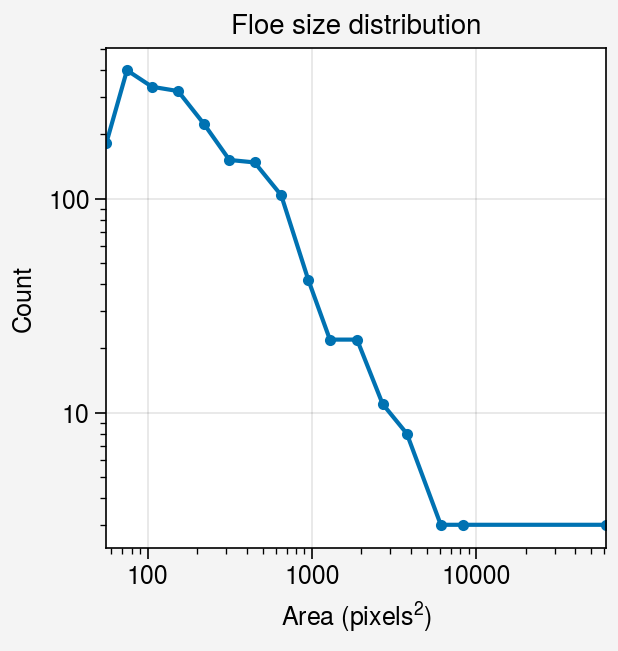

In [2]:
fig, ax = pplt.subplots()
ax.plot(df_rotation[['area', 'area_bin']].groupby('area_bin').mean()['area'].values,
        df_rotation.groupby('area_bin').count()['area'].values, marker='.')
ax.format(yscale='log', xscale='log', title='Floe size distribution', xlabel='Area (pixels$^2$)', ylabel='Count')
fig.save('../figures/fsd_rotation_experiment.png', dpi=300)

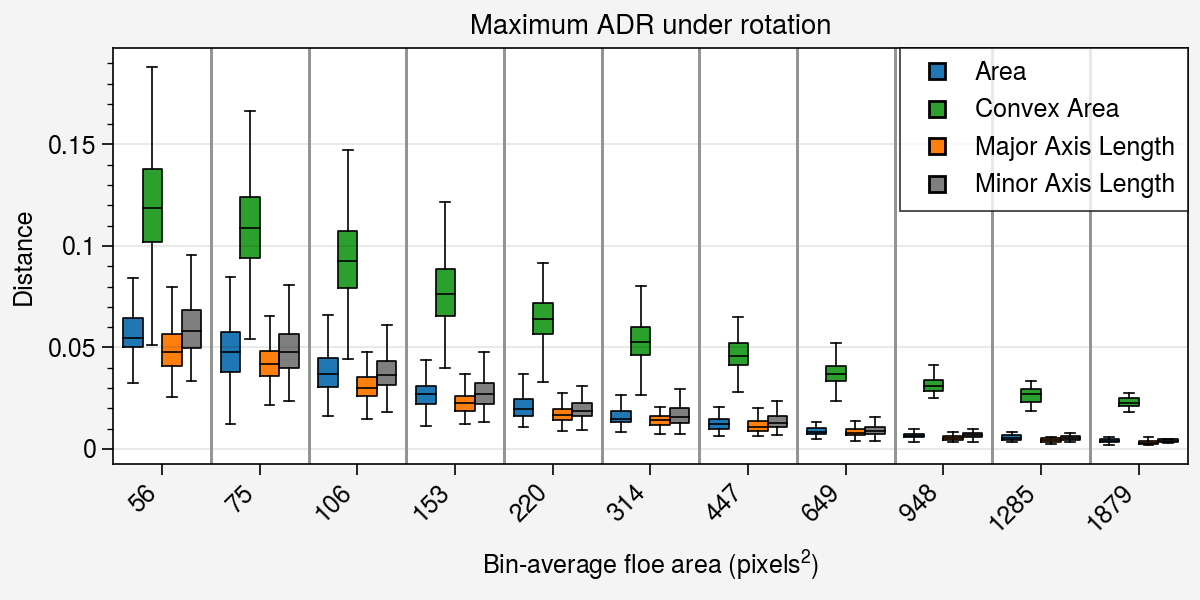

In [3]:
# could make this a function
df = df_rotation.copy()

bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

fig, ax = pplt.subplots(width=6, height=3)
h = []
for var, color, offset in zip(['max_adr_area', 'max_adr_convex_area',
                       'max_adr_major_axis_length', 'max_adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_area_count['count'] > 20]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))

    # Draw grid lines
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(4.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in bin_area_count.area.round().values.squeeze()], xrotation=45,
         title='Maximum ADR under rotation', xlabel='Bin-average floe area (pixels$^2$)', ylabel='Distance',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.save('../figures/../figures/maximum_adr_rotation_boxplot.png', dpi=300)

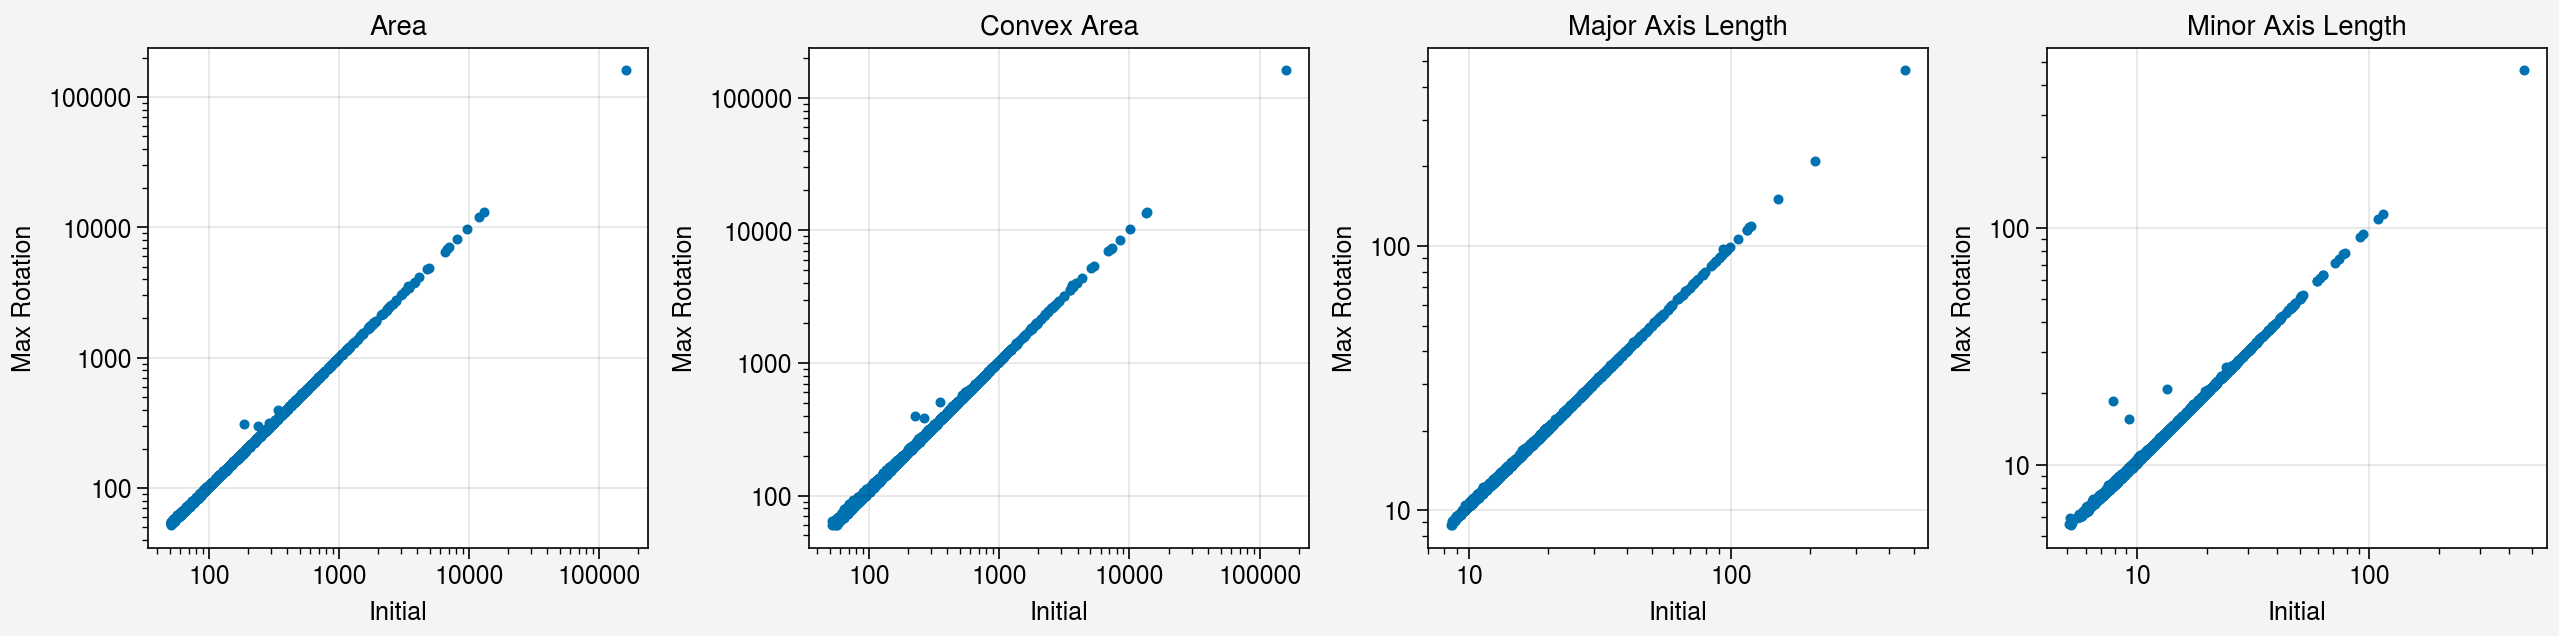

In [4]:
fig, axs = pplt.subplots(ncols=4, share=False)
for ax, var in zip(axs, ['area', 'convex_area', 'major_axis_length', 'minor_axis_length']):
    ax.scatter(df_rotation[var],
               df_rotation['max_' + var], m='.')
    ax.format(xlabel='Initial', ylabel='Max Rotation', title=var.replace('_', ' ').title(), xscale='log', yscale='log')
fig.save('../figures/scatter_comp_rotation_floes.png', dpi=300)

# Matched pairs experiment

In [5]:
#### Load the data both for the matches and for the inital images #####
dataloc = '../../eval_seg/data/floe_property_tables/matched/'
files = os.listdir(dataloc)
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + f))
df_matched = pd.concat(data)
dataloc = '../../eval_seg/data/floe_property_tables/aqua/'
files = os.listdir(dataloc)
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + f))
df_aqua = pd.concat(data)
dataloc = '../../eval_seg/data/floe_property_tables/terra/'
files = os.listdir(dataloc)
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + f))
df_terra = pd.concat(data)

df_matched = df_matched.dropna()
df_matched['case_number'] = [str(int(x)).zfill(3) for x in df_matched['case_number']]
df_terra['case_number'] = [str(int(x)).zfill(3) for x in df_terra['case_number']]
df_aqua['case_number'] = [str(int(x)).zfill(3) for x in df_aqua['case_number']]

df_merged = df_matched.merge(df_aqua[['label', 'case_number', 'axis_major_length', 'axis_minor_length', 'convex_area']], 
                 left_on=['aqua_label', 'case_number'], right_on=['label', 'case_number'],
                 suffixes=[None, '_aqua'], how='inner').merge(
    df_terra[['label', 'case_number', 'axis_major_length', 'axis_minor_length', 'convex_area']], 
                 left_on=['terra_label', 'case_number'], right_on=['label', 'case_number'],
                 suffixes=[None, '_terra'], how='inner')
df_merged.rename({'axis_major_length': 'axis_major_length_aqua',
                  'axis_minor_length': 'axis_minor_length_aqua',
                  'aqua_area': 'area_aqua',
                  'terra_area': 'area_terra',
                  'convex_area': 'convex_area_aqua'}, axis=1, inplace=True)


/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_22740/1830507418.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aqua = pd.concat(data)
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_22740/1830507418.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_terra = pd.concat(data)


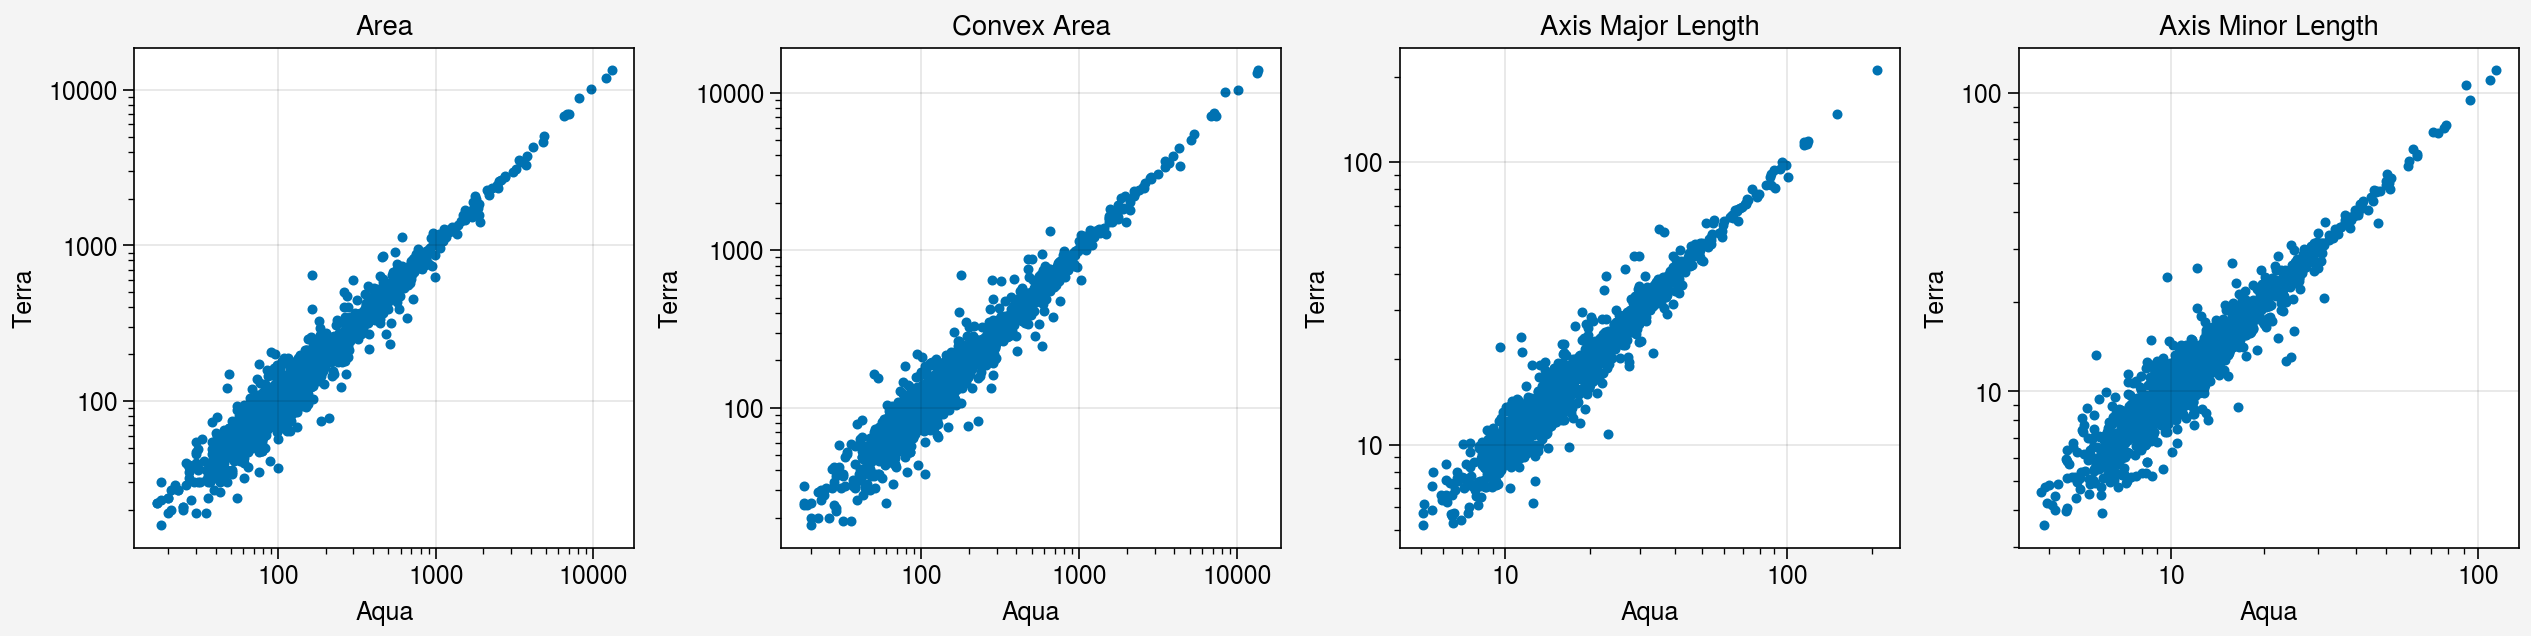

In [6]:
fig, axs = pplt.subplots(ncols=4, share=False)
for ax, var in zip(axs, ['area', 'convex_area', 'axis_major_length', 'axis_minor_length']):
    ax.scatter(df_merged[var + '_aqua'],
               df_merged[var + '_terra'], m='.')
    ax.format(xlabel='Aqua', ylabel='Terra', title=var.replace('_', ' ').title())
axs.format(yscale='log', xscale='log')
fig.save('../figures/scatter_comp_matched_floes.png', dpi=300)

In [7]:
df_merged['adr_area'] = 2*np.abs(df_merged['area_aqua'] - df_merged['area_terra'])/(df_merged['area_aqua'] + df_merged['area_terra'])
df_merged['adr_major_axis_length'] = 2*np.abs(df_merged['axis_major_length_aqua'] - df_merged['axis_major_length_terra'])/(df_merged['axis_major_length_aqua'] + df_merged['axis_major_length_terra'])
df_merged['adr_minor_axis_length'] = 2*np.abs(df_merged['axis_minor_length_aqua'] - df_merged['axis_minor_length_terra'])/(df_merged['axis_minor_length_aqua'] + df_merged['axis_minor_length_terra'])
df_merged['adr_convex_area'] = 2*np.abs(df_merged['convex_area_aqua'] - df_merged['convex_area_terra'])/(df_merged['convex_area_aqua'] + df_merged['convex_area_terra'])

df_merged['area'] = 1/2*(df_merged['area_aqua'] + df_merged['area_terra'])
df_merged['area_bin'] = np.digitize(df_merged['area'], bins)
df_merged = df_merged.loc[df_merged.area > 50].copy()


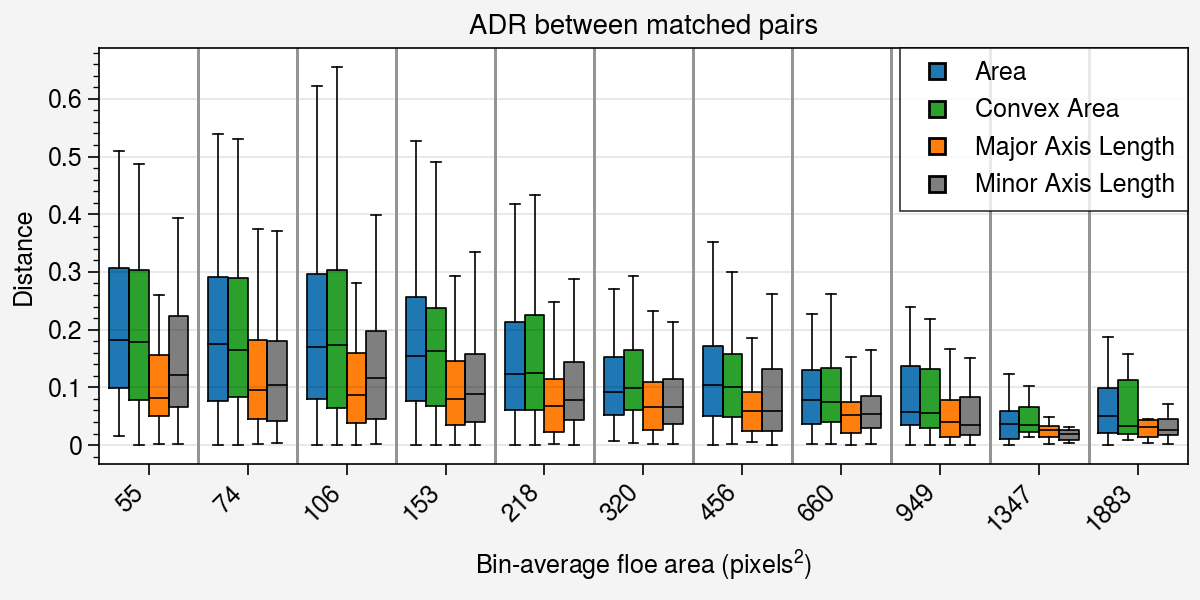

In [8]:
fig, ax = pplt.subplots(width=6, height=3)
h = []
df = df_merged.copy()
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']
for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    # bin_area_ave = df[['area_bin', 'area']].groupby('area_bin').mean()
    plot_data = plot_data.loc[:, bin_area_count['count'] > 10]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(4.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in bin_area_count.area.round().values.squeeze()], xrotation=45,
         title='ADR between matched pairs', xlabel='Bin-average floe area (pixels$^2$)', ylabel='Distance',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.save('../figures/../figures/adr_matched_boxplot.png', dpi=300)

# Unmatched pairs experiment
We test the background variability of the floe metrics by looking at pairs that are known not to be matches. We select all the Aqua image, then, within each area bin, we find the full list of combinations (possible pairs, no repeats, order doesn't matter), and draw a sample of 1000 of each of the random pairs. Then, we compute the ADR between each pair.

In [9]:
import itertools
import numpy as np

In [10]:
df_aqua['floe_id'] = [cn + '_' + str(int(lb)).zfill(3) for cn, lb in zip(df_aqua['case_number'],
                                                                         df_aqua['label'])]
df_aqua.set_index('floe_id', drop=True, inplace=True)
df_aqua['area_bins'] = np.digitize(df_aqua['area'], bins)

In [11]:
def adr(d1, d2, v):
    return 2*np.abs(d1[v].values - d2[v].values)/(d1[v].values + d2[v].values)

results = []
for bn, data in df_aqua.groupby('area_bins'):
    if data.area.min() > 50:
        if len(data) > 20:
            c = itertools.combinations(data.index, 2)
            rng = np.random.default_rng(seed=5 + bn)
            n = 1000
            pairs = rng.choice(list(c), n)
            f = pairs[:,0]
            g = pairs[:, 1]
            results.append(
                pd.DataFrame(
                    {'adr_area': np.round(adr(data.loc[f], data.loc[g], 'area'), 4),
                     'adr_convex_area':  np.round(adr(data.loc[f], data.loc[g], 'convex_area'), 4),
                     'adr_major_axis_length':  np.round(adr(data.loc[f], data.loc[g], 'axis_major_length'), 4),
                     'adr_minor_axis_length': np.round(adr(data.loc[f], data.loc[g], 'axis_minor_length'), 4),
                     'area_first': data.loc[f, 'area'].values,
                     'area_second': data.loc[g, 'area'].values,
                     'area': 1/2*(data.loc[f, 'area'].values + data.loc[g, 'area'].values),
                     'area_bin': bn}
                ))
            
df_random = pd.concat(results)  

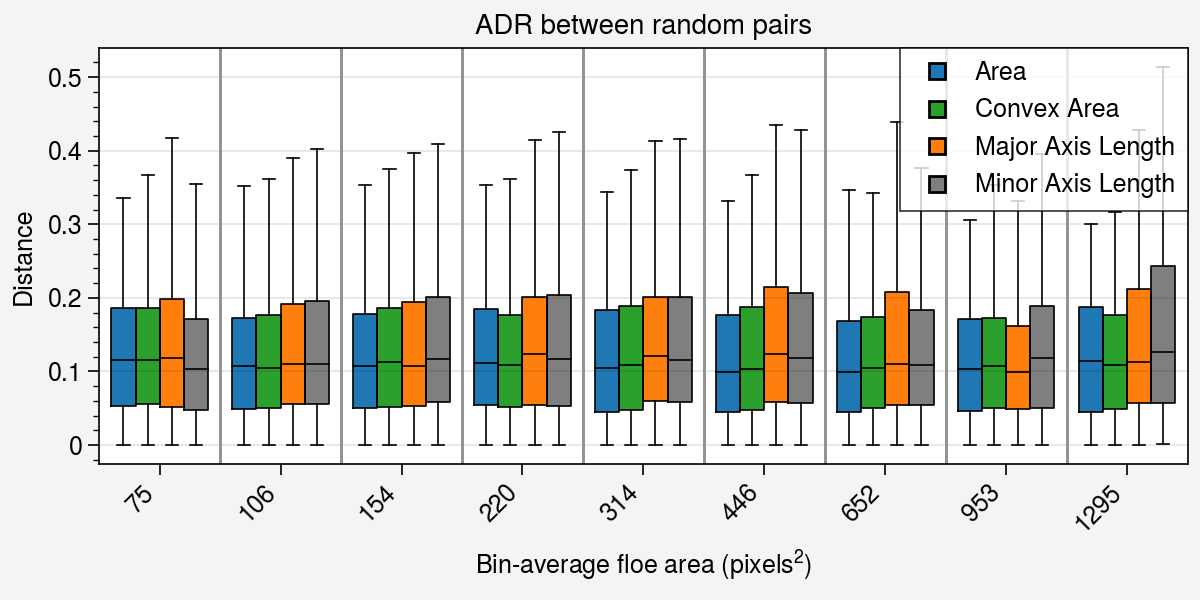

In [12]:
fig, ax = pplt.subplots(width=6, height=3)
h = []
df = df_random.copy()
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(5.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in bin_area_count.area.round().values.squeeze()], xrotation=45,
         title='ADR between random pairs', xlabel='Bin-average floe area (pixels$^2$)', ylabel='Distance',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.save('../figures/../figures/adr_random_boxplot.png', dpi=300)

Finally, we overlay the matched pair results on the random pair results.

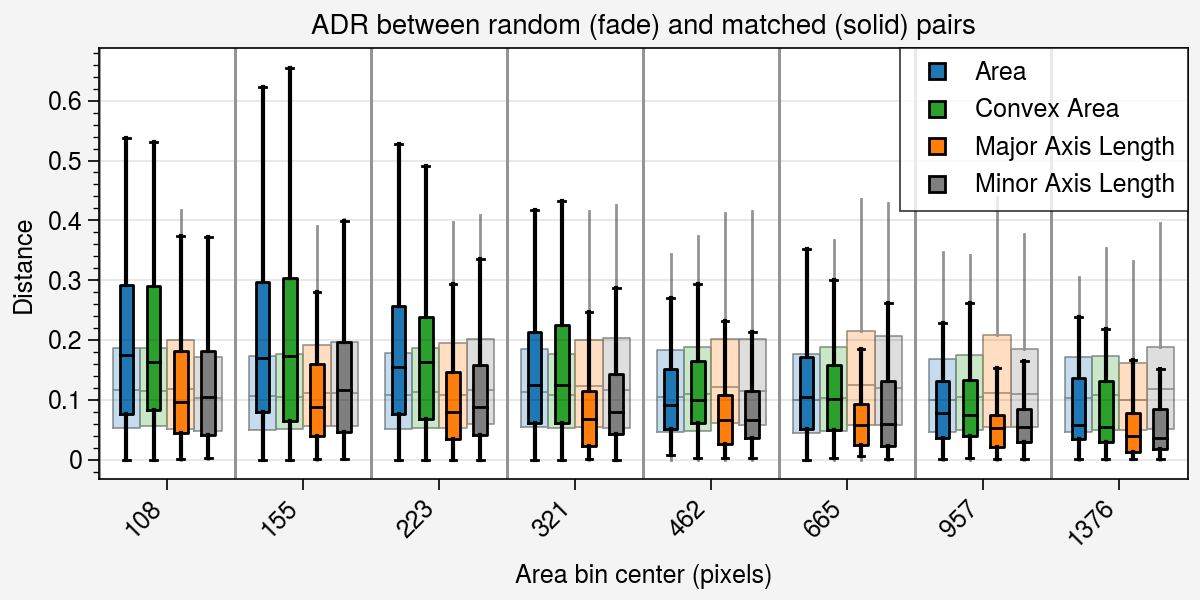

In [13]:
bcenter = 0.5*(bins[1:] + bins[:-1])

fig, ax = pplt.subplots(width=6, height=3)
h = []
df = df_random.copy()
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, whiskerlinewidths=1
           , ec='gray', caplinewidths=0,
           widths=0.2, alpha=0.25, zorder=0)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='light gray')

df = df_merged.copy()
df = df.loc[df.area > 50]
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_area_count['count'] > 20]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.1, zorder=5, lw=1, whiskerlinewidth=1.5)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(5.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in np.round(bcenter[bin_area_count[bin_area_count['count'] > 20].index])], xrotation=45,
         title='ADR between random (fade) and matched (solid) pairs',
          xlabel='Area bin center (pixels)', ylabel='Distance',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.save('../figures/../figures/adr_merged_random_boxplot.png', dpi=300)

# Summary of tests.
## Rotation errors
The error in ADR measurements due to rotation rate is fairly small, except in the case of convex area. For convex area, median error decreases from 12 to 2.5% as the floe area increases from 50 to over 1200 pixels. Values larger than 15% are possible for floes smaller than 100 pixels. For the other three measurements (area, major axis length, minor axis length), median error decreases from around 8% to less than 1%. 

## Inter-image variation errors
Errors due to differences in best-estimate manual outlines of paired floes give an indication of errors due to the uncertainty in the floe shape. Differences in illumination, cloud cover, and ice compactness affect the accuracy of manual floe identification. The ADR values are much larger for the matched pairs than for the rotated floes, telling us that differences in the appearance of floes from image to image is a larger source of uncertainty than difference in floe orientation. Measures of axis length show smaller ADR values than do the area measures. Both decrease is floe size increases.

## Random errors
Randomly pairing objects within area bins results in nearly constant distributions with area. The matched pair distributions of area, strangely enough, show larger differences than the random pairs. Only with large floes do the differences seem noticebly smaller than the random variations. 

# Finding best-performing thresholds
We can think of this in terms of precision and recall: for each possible threshold, we end up labeling pairings as candidates and non-candidates. A false positive is a candidate that is not a true match, a false negative is rejecting a true match. With 4 metrics, should it be done one at a time? Or with all simultaneously? How sensitive is the final choice?


In [21]:
area_threshold = 0.24
# precision = true positives / (true positives + false positives)
# recall = true positives / (true positives + false negatives)

In [18]:
df_merged['true_match'] = True
df_random['true_match'] = False
df_all = pd.concat([df_random[['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length', 'true_match']],
                    df_merged[['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length', 'true_match']]])

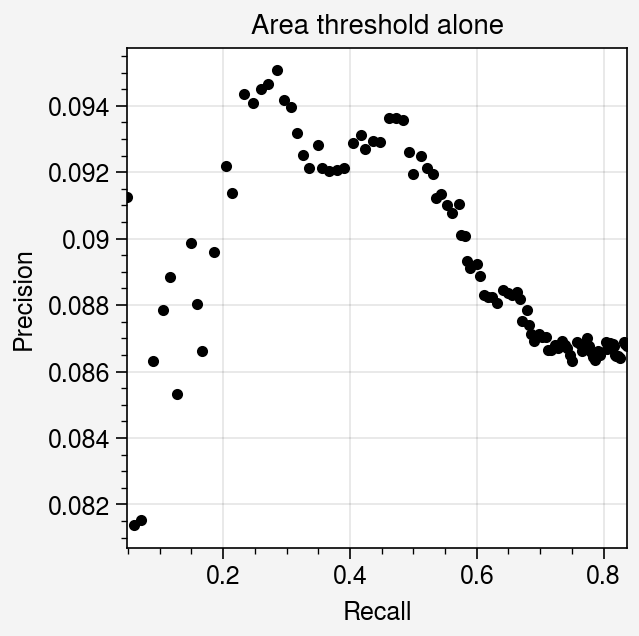

In [27]:
fig, ax = pplt.subplots()
for area_threshold in np.linspace(0.01, 0.3, 100):
    test_result = df_all['adr_area'] < area_threshold
    truth = df_all['true_match']
    precision = np.sum(test_result & truth) / np.sum(test_result)
    recall = np.sum(test_result & truth) / np.sum(truth)
    ax.plot(recall, precision, marker='.', color='k')
ax.format(ylabel='Precision', xlabel='Recall', title='Area threshold alone')

(0.08690205011389522, 0.7614770459081837)

# Moving forward
It's not obvious that we need all 4 measures -- what is added by convex area, for example, that's not covered by area?